In [235]:
data_path = "store-sales-time-series-forecasting"

In [236]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from sklearn import preprocessing 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

# Model 1 (trend)
#from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain
import warnings


# Super Table

Let us start combining all the tables accordingly

In [237]:
df_transactions = pd.read_csv(data_path+'\\transactions.csv')
df_train = pd.read_csv(data_path+'\\train.csv')
df_test = pd.read_csv(data_path+'\\test.csv')
df_store = pd.read_csv(data_path+'\\stores.csv')
df_oil = pd.read_csv(data_path+'\\oil.csv')
df_holiday = pd.read_csv(data_path+'\\holidays_events.csv')


In [238]:
df_holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [239]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [240]:
df_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [241]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## Combining stores,transactions,oil,holidays one by one

In [242]:
#df_oil,df_holiday join
df_megaA = pd.merge(df_oil, df_holiday, how="left", on="date")
#df_stores,df_transactions join
df_megaB = pd.merge(df_transactions,df_store, how="left", on="store_nbr")



In [243]:
df_megaA.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236 entries, 0 to 1235
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1236 non-null   object 
 1   dcoilwtico   1190 non-null   float64
 2   type         202 non-null    object 
 3   locale       202 non-null    object 
 4   locale_name  202 non-null    object 
 5   description  202 non-null    object 
 6   transferred  202 non-null    object 
dtypes: float64(1), object(6)
memory usage: 77.2+ KB


C:\Users\archi\AppData\Local\Temp\ipykernel_2880\1151397908.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df_megaA.info(verbose=True,null_counts=True)


In [244]:
df_megaB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83488 entries, 0 to 83487
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
 3   city          83488 non-null  object
 4   state         83488 non-null  object
 5   type          83488 non-null  object
 6   cluster       83488 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.1+ MB


In [245]:
#df_stores,df_transactions join
df_mega_ONE = pd.merge(df_megaB,df_megaA, how="left", on="date")
df_mega_ONE = df_mega_ONE.drop(['description'], axis=1)
df_mega_ONE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84382 entries, 0 to 84381
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          84382 non-null  object 
 1   store_nbr     84382 non-null  int64  
 2   transactions  84382 non-null  int64  
 3   city          84382 non-null  object 
 4   state         84382 non-null  object 
 5   type_x        84382 non-null  object 
 6   cluster       84382 non-null  int64  
 7   dcoilwtico    58585 non-null  float64
 8   type_y        9759 non-null   object 
 9   locale        9759 non-null   object 
 10  locale_name   9759 non-null   object 
 11  transferred   9759 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 8.4+ MB


# Building Training Dataset

In [232]:
#df_stores,df_transactions join
df_mega_train = pd.merge(df_mega_ONE,df_train, how="left", on=["date","store_nbr"])
df_mega_train['date'] = pd.to_datetime(df_mega_train['date'])
df_mega_train['day'] = df_mega_train['date'].apply(lambda x: x.day)
df_mega_train['month'] = df_mega_train['date'].apply(lambda x: x.month)
df_mega_train['year'] = df_mega_train['date'].apply(lambda x: x.year)
df_mega_train['week_of_month'] = df_mega_train['date'].apply(lambda x: x.isocalendar()[1])
df_mega_train['day_of_week'] = df_mega_train['date'].apply(lambda x: x.isocalendar()[2])
df_mega_train = df_mega_train.drop(['id'], axis=1)

df_mega_train['type_y'].fillna("Work", inplace=True)
df_mega_train['locale'].fillna("Global", inplace=True)
df_mega_train['locale_name'].fillna("Global", inplace=True)
df_mega_train['transferred'].fillna("NA", inplace=True)

df_mega_train.head()

,date,store_nbr,transactions,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,transferred,family,sales,onpromotion,day,month,year,week_of_month,day_of_week
0,2013-01-01,25,770,Salinas,Santa Elena,D,1,93.14,Holiday,National,Ecuador,False,AUTOMOTIVE,0.0,0,1,1,2013,1,2
1,2013-01-01,25,770,Salinas,Santa Elena,D,1,93.14,Holiday,National,Ecuador,False,BABY CARE,0.0,0,1,1,2013,1,2
2,2013-01-01,25,770,Salinas,Santa Elena,D,1,93.14,Holiday,National,Ecuador,False,BEAUTY,2.0,0,1,1,2013,1,2
3,2013-01-01,25,770,Salinas,Santa Elena,D,1,93.14,Holiday,National,Ecuador,False,BEVERAGES,810.0,0,1,1,2013,1,2
4,2013-01-01,25,770,Salinas,Santa Elena,D,1,93.14,Holiday,National,Ecuador,False,BOOKS,0.0,0,1,1,2013,1,2


In [233]:
df_mega_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2784606 entries, 0 to 2784605
Data columns (total 20 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   date           2784606 non-null  datetime64[ns]
 1   store_nbr      2784606 non-null  int64         
 2   transactions   2784606 non-null  int64         
 3   city           2784606 non-null  object        
 4   state          2784606 non-null  object        
 5   type_x         2784606 non-null  object        
 6   cluster        2784606 non-null  int64         
 7   dcoilwtico     1997985 non-null  float64       
 8   type_y         2784606 non-null  object        
 9   locale         2784606 non-null  object        
 10  locale_name    2784606 non-null  object        
 11  transferred    2784606 non-null  object        
 12  family         2784606 non-null  object        
 13  sales          2784606 non-null  float64       
 14  onpromotion    2784606 non-null  i

## Filling Null Values

In [234]:
df_mega_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2784606 entries, 0 to 2784605
Data columns (total 20 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   date           2784606 non-null  datetime64[ns]
 1   store_nbr      2784606 non-null  int64         
 2   transactions   2784606 non-null  int64         
 3   city           2784606 non-null  object        
 4   state          2784606 non-null  object        
 5   type_x         2784606 non-null  object        
 6   cluster        2784606 non-null  int64         
 7   dcoilwtico     1997985 non-null  float64       
 8   type_y         2784606 non-null  object        
 9   locale         2784606 non-null  object        
 10  locale_name    2784606 non-null  object        
 11  transferred    2784606 non-null  object        
 12  family         2784606 non-null  object        
 13  sales          2784606 non-null  float64       
 14  onpromotion    2784606 non-null  i

In [30]:
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [31]:
def add_time(df, key, freq, col):
    """ ADD COLUMN 'TIME' TO DF """
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [32]:
# check grouped data
df_grouped_trans_w = grouped(df_mega_train, 'date', 'W', 'transactions')
df_grouped_sales_w = add_time(df_mega_train, 'date', 'W', 'sales')
df_grouped_sales_m = add_time(df_mega_train, 'date', 'M', 'sales')

In [33]:
df_grouped_trans_w

,date,mean
0,2013-01-06,1883.203463
1,2013-01-13,1641.090062
2,2013-01-20,1639.024845
3,2013-01-27,1609.816770
4,2013-02-03,1685.263975
...,...,...
237,2017-07-23,1623.208995
238,2017-07-30,1619.653439
239,2017-08-06,1713.743386
240,2017-08-13,1599.156085


<Axes: xlabel='date', ylabel='mean'>

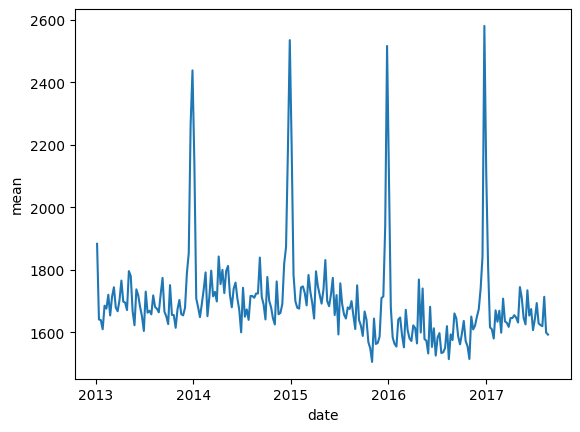

In [34]:
sns.lineplot(x='date', 
            y='mean', 
            data=df_grouped_trans_w, 
            )

<Axes: xlabel='time', ylabel='mean'>

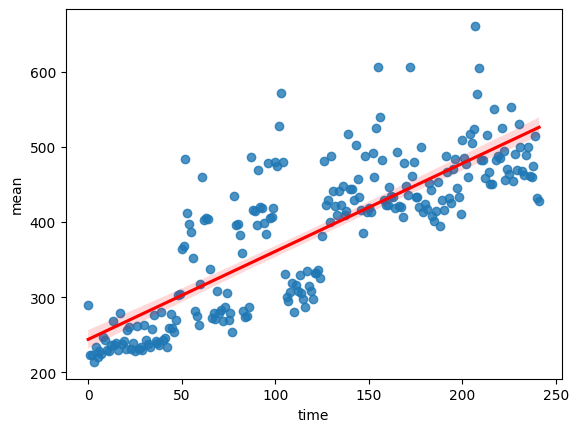

In [35]:
sns.regplot(x='time', 
            y='mean', 
            data=df_grouped_sales_w, 
            #scatter_kws=dict(color='0.75'), 
            line_kws={"color": "red"},
            )

<Axes: xlabel='time', ylabel='mean'>

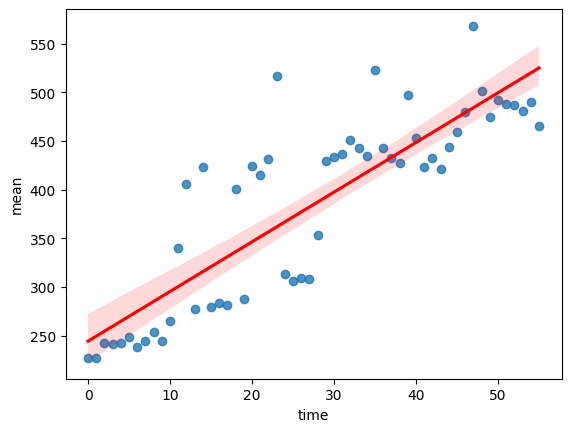

In [36]:
sns.regplot(x='time', 
            y='mean', 
            data=df_grouped_sales_m, 
            #scatter_kws=dict(color='0.75'), 
            line_kws={"color": "red"},
            )